# Easy Money - Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,\
    plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from datetime import datetime
from xgboost import XGBClassifier, plot_importance
from xgboost import plot_tree

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Configurations

Para la validación solo dejamos el último mes, porque es el mes que nos interesa para la recomendación de productos. Para desarrollo (train+test) - 16 meses Train: 80% de esos 16 meses Test: 20% random Validación: último mes.

In [3]:
TARGET = "short_term_deposit"

__DATA_PATH__ = "../../data"
__DATASET__ = f"{__DATA_PATH__}/processed/easy_money_classification.csv"
__MODEL_METRICS_REPORT_PATH__ = "../../reports/model_evaluation_output.csv"
__POTENTIAL_CLIENTS_PATH__ = "../../reports/potential_clients"

DEV_PARTITION_PERIOD = ("2018-01-28", "2019-04-28")
VAL_PARTITION_PERIOD = ("2019-05-28", "2019-05-28")

EXCLUDE_COLUMNS = ["pk_cid", "pk_partition"]
RANDOM_STATE = 123
DO_UNDER_SAMPLING = True
IS_RUNNING_LOCAL = True

## Import data

In [4]:
dtypes = {'pk_cid': 'int64', 'active_customer': 'int8',
          'region_code': 'int8', 'gender': 'int8', 'age': 'int8', 'deceased': 'int8',
          'short_term_deposit': 'int8', 'loans': 'int8', 'mortgage': 'int8',
          'funds': 'int8', 'securities': 'int8', 'long_term_deposit': 'int8',
          'em_account_pp': 'int8', 'credit_card': 'int8', 'payroll': 'int8',
          'pension_plan': 'int8', 'payroll_account': 'int8', 'emc_account': 'int8',
          'debit_card': 'int8', 'em_account_p': 'int8', 'em_acount': 'int8',
          'entry_date_month': 'int8', 'entry_date_year': 'int8', 'entry_date_day': 'int8',
          'entry_date_week': 'int8', 'entry_date_weekday': 'int8', 'entry_date_trim': 'int8',
          'salary': 'float64', 'entry_channel_004': 'int8', 'entry_channel_007': 'int8',
          'entry_channel_013': 'int8', 'entry_channel_KAA': 'int8', 'entry_channel_KAB': 'int8',
          'entry_channel_KAD': 'int8', 'entry_channel_KAE': 'int8', 'entry_channel_KAF': 'int8',
          'entry_channel_KAG': 'int8', 'entry_channel_KAH': 'int8', 'entry_channel_KAI': 'int8',
          'entry_channel_KAJ': 'int8', 'entry_channel_KAK': 'int8', 'entry_channel_KAM': 'int8',
          'entry_channel_KAQ': 'int8', 'entry_channel_KAR': 'int8', 'entry_channel_KAS': 'int8',
          'entry_channel_KAT': 'int8', 'entry_channel_KAW': 'int8', 'entry_channel_KAY': 'int8',
          'entry_channel_KAZ': 'int8', 'entry_channel_KBE': 'int8', 'entry_channel_KBG': 'int8',
          'entry_channel_KBH': 'int8', 'entry_channel_KBO': 'int8', 'entry_channel_KBU': 'int8',
          'entry_channel_KBW': 'int8', 'entry_channel_KBY': 'int8', 'entry_channel_KBZ': 'int8',
          'entry_channel_KCB': 'int8', 'entry_channel_KCC': 'int8', 'entry_channel_KCH': 'int8',
          'entry_channel_KCI': 'int8', 'entry_channel_KCK': 'int8', 'entry_channel_KCL': 'int8',
          'entry_channel_KDA': 'int8', 'entry_channel_KDH': 'int8', 'entry_channel_KDR': 'int8',
          'entry_channel_KDS': 'int8', 'entry_channel_KDT': 'int8', 'entry_channel_KEH': 'int8',
          'entry_channel_KEJ': 'int8', 'entry_channel_KES': 'int8', 'entry_channel_KEY': 'int8',
          'entry_channel_KFA': 'int8', 'entry_channel_KFC': 'int8', 'entry_channel_KFD': 'int8',
          'entry_channel_KFF': 'int8', 'entry_channel_KFK': 'int8', 'entry_channel_KFL': 'int8',
          'entry_channel_KFP': 'int8', 'entry_channel_KFS': 'int8', 'entry_channel_KGC': 'int8',
          'entry_channel_KGN': 'int8', 'entry_channel_KGX': 'int8', 'entry_channel_KHC': 'int8',
          'entry_channel_KHD': 'int8', 'entry_channel_KHE': 'int8', 'entry_channel_KHF': 'int8',
          'entry_channel_KHK': 'int8', 'entry_channel_KHL': 'int8', 'entry_channel_KHM': 'int8',
          'entry_channel_KHN': 'int8', 'entry_channel_KHO': 'int8', 'entry_channel_KHP': 'int8',
          'entry_channel_KHQ': 'int8', 'entry_channel_KHS': 'int8', 'entry_channel_RED': 'int8',
          'entry_channel_UNKNOWN': 'int8', 'segment_00 - OTROS': 'int8',
          'segment_01 - TOP': 'int8', 'segment_02 - PARTICULARES': 'int8',
          'segment_03 - UNIVERSITARIO': 'int8', 'country_id_AR': 'int8', 'country_id_AT': 'int8',
          'country_id_BE': 'int8', 'country_id_BR': 'int8', 'country_id_CA': 'int8',
          'country_id_CH': 'int8', 'country_id_CI': 'int8', 'country_id_CL': 'int8',
          'country_id_CM': 'int8', 'country_id_CN': 'int8', 'country_id_CO': 'int8',
          'country_id_DE': 'int8', 'country_id_DJ': 'int8', 'country_id_DO': 'int8',
          'country_id_DZ': 'int8', 'country_id_ES': 'int8', 'country_id_ET': 'int8',
          'country_id_FR': 'int8', 'country_id_GA': 'int8', 'country_id_GB': 'int8',
          'country_id_GT': 'int8', 'country_id_HU': 'int8', 'country_id_IE': 'int8',
          'country_id_IT': 'int8', 'country_id_JM': 'int8', 'country_id_LU': 'int8',
          'country_id_MA': 'int8', 'country_id_MR': 'int8', 'country_id_MX': 'int8',
          'country_id_NO': 'int8', 'country_id_PE': 'int8', 'country_id_PL': 'int8',
          'country_id_PT': 'int8', 'country_id_QA': 'int8', 'country_id_RO': 'int8',
          'country_id_RU': 'int8', 'country_id_SA': 'int8', 'country_id_SE': 'int8',
          'country_id_SN': 'int8', 'country_id_US': 'int8', 'country_id_VE': 'int8'}

parse_dates = ['pk_partition']

In [5]:
%%time
df = pd.read_csv(__DATASET__, dtype=dtypes, parse_dates=parse_dates)
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("entry_date", axis=1, inplace=True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962838 entries, 0 to 5962837
Columns: 143 entries, pk_cid to country_id_VE
dtypes: datetime64[ns](1), float64(1), int64(1), int8(140)
memory usage: 932.6 MB
Wall time: 38.3 s


In [6]:
df.head(20)

,pk_cid,pk_partition,active_customer,region_code,gender,age,deceased,short_term_deposit,loans,mortgage,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,15891,2018-07-28,1,28,1,59,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15891,2018-08-28,0,28,1,59,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16063,2018-11-28,1,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16063,2018-12-28,1,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16063,2019-01-28,1,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,16063,2019-02-28,1,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,16063,2019-03-28,0,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,16063,2019-04-28,1,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,16063,2019-05-28,0,28,1,62,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,16203,2018-12-28,0,8,0,70,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,5962838.0,1.234933e+06,162293.085772,15891.0,1112533.0,1231097.0,1352339.75,1553689.0
active_customer,5962838.0,4.033799e-01,0.490576,0.0,0.0,0.0,1.00,1.0
region_code,5962838.0,2.580417e+01,13.603136,-1.0,13.0,28.0,36.00,52.0
gender,5962838.0,5.177870e-01,0.499684,0.0,0.0,1.0,1.00,1.0
age,5962838.0,2.976015e+01,11.980074,2.0,22.0,25.0,34.00,105.0
...,...,...,...,...,...,...,...,...
country_id_SA,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_SE,5962838.0,2.683286e-06,0.001638,0.0,0.0,0.0,0.00,1.0
country_id_SN,5962838.0,2.850991e-06,0.001688,0.0,0.0,0.0,0.00,1.0
country_id_US,5962838.0,3.270255e-05,0.005719,0.0,0.0,0.0,0.00,1.0


## Classes

In [8]:
class EasyMoneyFilter(BaseEstimator, TransformerMixin):
    """
    Filtro que toma el registro de la primera compra del target
    y un 0 al azar, en caso de que nunca hubo compra
    se regresa un solo registro (aleatoriamente) y en caso
    de que todos fueran compras, devuelve solo la primera
    """

    def __init__(self, target: str, group_by="pk_cid", sort_value=None):
        if sort_value is None:
            sort_value = ["pk_cid", "pk_partition"]
        self.target = target
        self.group_by = group_by
        self.sort_values = sort_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.concat([
            self.get_fist_sales(X),
            self.get_random_no_sales(X)
        ]).sort_values(self.sort_values, ignore_index=True)

    def get_fist_sales(self, X) -> pd.DataFrame:
        first_sale = X.groupby([self.group_by, self.target]).first().reset_index()
        return first_sale[first_sale[self.target] == 1]

    def get_random_no_sales(self, X) -> pd.DataFrame:
        return X[X[self.target] == 0].groupby(self.group_by).sample(n=1, random_state=RANDOM_STATE)

    def get_last_no_sales(self, X) -> pd.DataFrame:
        last_no_sale = X.groupby([self.group_by, self.target]).last().reset_index()
        return last_no_sale[last_no_sale[self.target] == 0]


class EasyMoneySplitter:
    """
    Divide el dataset en la particion de desarrollo y la de validacion segun los rangos
    de fechas indicadas en los parametros dev_partition_period y val_partition_period.
    exclude_columns Si se indican campos a ser excluidos
    """

    def __init__(self, dev_partition_period: tuple, val_partition_period: tuple):
        self.dev_partition_period = dev_partition_period
        self.val_partition_period = val_partition_period

    def get_train_partition(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        """
        Obtiene la particion de train
        :param dataframe: dataframe que quiera particionar
        :return: dataframe particion para train (ya excluidos los campos indicados)
        """
        # partition = self._split(dataframe, self.dev_partition_period[0], self.dev_partition_period[1])
        return self._split(dataframe, self.dev_partition_period[0], self.dev_partition_period[1])

    def get_validation_partition(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        """
        Obtiene particion de validacion
        :param dataframe: dataframe que quiera particionar
        :return: dataframe particion para validacion (ya excluidos los campos indicados)
        """
        return self._split(dataframe, self.val_partition_period[0], self.val_partition_period[1])

    def _split(self, dataframe: pd.DataFrame, from_date, to_date) -> pd.DataFrame:
        return dataframe[dataframe["pk_partition"].between(from_date, to_date)].reset_index(drop=True)

    @staticmethod
    def under_sample(dataframe: pd.DataFrame, target: str, is_mostly_zero: bool) -> pd.DataFrame:
        """
        Realiza undersampling
        :param dataframe: dataframe a procesar
        :param target: target
        :param is_mostly_zero: cual clase es la mayoritaria
        :return: dataframe sampleado
        """
        non_zeros = dataframe[dataframe[target] == 1]
        zeros = dataframe[dataframe[target] == 0]
        if is_mostly_zero:
            n_zeros = len(non_zeros) * 4
            zeros = zeros.sample(n=n_zeros, random_state=RANDOM_STATE)
        else:
            n_non_zeros = len(zeros) * 4
            non_zeros = non_zeros.sample(n=n_non_zeros, random_state=RANDOM_STATE)

        return pd.concat([zeros, non_zeros])


class Reporter:
    """
    Clase para registrar resultados de la modelizacion
    """

    def __init__(self, output_file):
        self.output_file = output_file
        try:
            print(self.output_file)
            self.output_df = pd.read_csv(self.output_file, index_col=0)
            self.output_df["date"] = pd.to_datetime(self.output_df["date"])
        except FileNotFoundError:
            self.output_df = pd.DataFrame(columns=[
                "target",
                "target_mean",
                "date",
                "is_overfitted",
                "roc_auc_train",
                "roc_auc_test",
                "roc_auc_val",
                "accuracy_train",
                "accuracy_test",
                "accuracy_val",
                "recall_train",
                "recall_test",
                "recall_val",
                "precision_train",
                "precision_test",
                "precision_val",
                "f1_score_train",
                "f1_score_test",
                "f1_score_val",
                "model"
            ])

    def append_new_evaluation(self, data: dict):
        """
        Agrega un nuevo registro en memoria
        :param data: metricas
        """
        data["is_overfitted"] = round(abs((data["roc_auc_train"] - data["roc_auc_test"])), 2) > 0
        data["date"] = datetime.now()
        self.output_df = self.output_df.append(data, ignore_index=True)

    def record_evaluation(self, target: str, model, X_train, y_train, X_test, y_test, X_val, y_val, target_mean):
        """
        Registra las metricas de los resultados de una modelizacion
        :param target: target
        :param model: Modelo
        :param X_train: dataset de train X
        :param y_train: labels de train Y
        :param X_test: dataset de test X
        :param y_test: labels de test y
        :param X_val: dataset de validacion X
        :param y_val: labels de validacion y
        :param target_mean: media global del target
        :return: Todas las metricas guardadas
        """
        train_metrics = get_metrics(model, X_train, y_train)
        test_metrics = get_metrics(model, X_test, y_test)
        val_metrics = get_metrics(model, X_val, y_val)
        report_dict = {
            "target": target,
            "roc_auc_train": train_metrics["roc_auc"],
            "roc_auc_test": test_metrics["roc_auc"],
            "roc_auc_val": val_metrics["roc_auc"],
            "accuracy_train": train_metrics["accuracy"],
            "accuracy_test": test_metrics["accuracy"],
            "accuracy_val": val_metrics["accuracy"],
            "recall_train": train_metrics["recall"],
            "recall_test": test_metrics["recall"],
            "recall_val": val_metrics["recall"],
            "precision_train": train_metrics["precision"],
            "precision_test": test_metrics["precision"],
            "precision_val": val_metrics["precision"],
            "f1_score_train": train_metrics["f1_score"],
            "f1_score_test": test_metrics["f1_score"],
            "f1_score_val": val_metrics["f1_score"],
            "target_mean": target_mean,
            "model": model
        }
        self.append_new_evaluation(report_dict)
        return self.save_csv()

    def save_csv(self):
        """
        Guarda en csv los resultados de las evaluaciones
        :return: Todas las metricas guardadas
        """
        self.output_df.drop_duplicates(keep="last", inplace=True)
        self.output_df.to_csv(self.output_file)
        return self.output_df


reporter = Reporter(__MODEL_METRICS_REPORT_PATH__)

../../reports/model_evaluation_output.csv


## Functions

In [9]:
def hist_plot(dataframe: pd.DataFrame, target: str):
    """
    Plotea un Histograma
    :param dataframe: dataframe a mostrar
    :param target: target
    :return: value_counts del dataframe de entrada
    """
    dataframe[target].hist()
    plt.show()
    print(target)
    return dataframe[target].value_counts()


def relation_with_target(dataframe: pd.DataFrame, field: str, target: str):
    """
    Describe la relacion de una variable contra el target
    usando un countplot y una pivot_table
    :param dataframe: dataframe a evaluar
    :param field: campo a contrastar con el target
    :param target: target
    :return: pivot table resumen
    """
    plt.figure(figsize=(15, 5))
    plt.xticks(rotation=90)
    sns.countplot(data=dataframe, x=field, hue=target)
    plt.show()
    return dataframe.pivot_table(index=field, values=target, aggfunc=[len, sum, np.mean])


def get_y_score(model, X, y) -> pd.DataFrame:
    """
    Obtiene el predictproba
    :param model: modelo
    :param X: datos a evaluar
    :param y: y para obtener los indices
    :return: predict_proba dataframe
    """
    return pd.DataFrame(model.predict_proba(X)[:, 1], index=y.index, columns=['score'])


def get_metrics(model, X, y):
    """
    Obtiene un diccionario con las metricas del modelo
    :param model: modelo
    :param X: datos a evaluar
    :param y: y
    :return: diccionario con metricas
    """
    prediction = model.predict(X)
    y_score = get_y_score(model, X, y)
    try:
        auc = roc_auc_score(y, y_score)
    except ValueError:
        auc = 0
    return dict({
        "roc_auc": auc,
        "accuracy": accuracy_score(y, prediction),
        "precision": precision_score(y, prediction),
        "recall": recall_score(y, prediction),
        "f1_score": f1_score(y, prediction),
    })

## Filter data

Filtramos los datos para no tener los 17 meses de un cliente sino capturar sus caracteristicas cuando obtuvo el producto por primera vez y tener una muestra de cuando no lo tuvo, aquí se hace un resumen de las características de cada usuario.

In [10]:
filter = EasyMoneyFilter(TARGET)
df_prep = filter.fit_transform(df)
df_prep

,pk_cid,short_term_deposit,pk_partition,active_customer,region_code,gender,age,deceased,loans,mortgage,...,country_id_PL,country_id_PT,country_id_QA,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE
0,15891,0,2018-08-28,0,28,1,59,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16063,0,2018-11-28,1,28,1,62,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16203,0,2019-04-28,1,8,0,70,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16502,0,2018-12-28,1,28,1,58,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17457,0,2018-06-28,1,28,1,53,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461688,1553685,0,2019-05-28,0,13,0,52,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461689,1553686,0,2019-05-28,0,41,1,30,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461690,1553687,0,2019-05-28,0,28,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
461691,1553688,0,2019-05-28,0,39,1,43,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Target distribution

In [11]:
df_prep.describe().T

,count,mean,std,min,25%,50%,75%,max
pk_cid,461693.0,1.275965e+06,178983.035400,15891.0,1145003.0,1287586.0,1423094.0,1553689.0
short_term_deposit,461693.0,1.153147e-02,0.106764,0.0,0.0,0.0,0.0,1.0
active_customer,461693.0,3.890009e-01,0.487524,0.0,0.0,0.0,1.0,1.0
region_code,461693.0,2.587934e+01,13.533878,-1.0,13.0,28.0,36.0,52.0
gender,461693.0,5.113614e-01,0.499871,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
country_id_SA,461693.0,2.165941e-06,0.001472,0.0,0.0,0.0,0.0,1.0
country_id_SE,461693.0,4.331883e-06,0.002081,0.0,0.0,0.0,0.0,1.0
country_id_SN,461693.0,2.165941e-06,0.001472,0.0,0.0,0.0,0.0,1.0
country_id_US,461693.0,3.248912e-05,0.005700,0.0,0.0,0.0,0.0,1.0


Gráfico general de los clientes en los 17 meses que tienen o no short_term_deposit

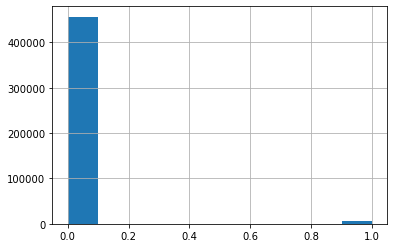

short_term_deposit


0    456369
1      5324
Name: short_term_deposit, dtype: int64

In [12]:
hist_plot(df_prep, TARGET)

Coolwarm: gráfico de correlación entre las variables, se puede apreciar que los campos short_term_deposit y em_account están muy correlacionados entre ellos

In [13]:
fields_for_corr = [
    'active_customer', 'gender', 'age', 'short_term_deposit',
    'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll', 'pension_plan',
    'payroll_account', 'emc_account', 'debit_card', 'em_account_p', 'em_acount',
    'salary', 'segment_00 - OTROS', 'segment_01 - TOP', 'segment_02 - PARTICULARES', 'segment_03 - UNIVERSITARIO'
]
fields_for_corr.remove(TARGET)
fields_for_corr.insert(0, TARGET)

corr = df_prep[fields_for_corr].corr()
corr.style.background_gradient(cmap="coolwarm")

,short_term_deposit,active_customer,gender,age,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,salary,segment_00 - OTROS,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
short_term_deposit,1.000000,0.102449,-0.019014,0.141594,0.000021,-0.003223,-0.001823,-0.007312,-0.014489,-0.014835,-0.017071,-0.016072,-0.024628,-0.000225,-0.023778,0.003046,0.024773,0.172243,0.069613,-0.125891
active_customer,0.102449,1.000000,-0.053087,0.238346,0.065990,0.070121,0.152749,0.120359,0.219456,0.225981,0.267615,0.216280,0.368033,0.002608,0.235021,-0.001916,-0.047494,0.148969,0.273261,-0.277394
gender,-0.019014,-0.053087,1.000000,-0.088119,-0.016930,-0.021051,-0.018538,-0.025312,-0.017032,-0.016787,-0.023730,-0.042941,-0.043610,-0.000047,0.033017,-0.001599,-0.018929,-0.026508,-0.116675,0.127597
age,0.141594,0.238346,-0.088119,1.000000,0.080344,0.066030,0.220090,0.092656,0.086063,0.103496,0.113607,0.246871,0.162956,0.003029,-0.147710,-0.002584,0.072807,0.250553,0.602137,-0.677544
funds,0.000021,0.065990,-0.016930,0.080344,1.000000,0.098010,0.139225,0.032540,0.020455,0.022159,0.024238,0.094106,0.021371,-0.000110,0.005932,0.005767,-0.013186,0.110156,0.032667,-0.054893
securities,-0.003223,0.070121,-0.021051,0.066030,0.098010,1.000000,0.031912,0.055909,0.039996,0.041186,0.039947,0.077390,0.053373,0.018355,0.010377,0.005795,-0.012998,0.068045,0.044119,-0.054273
long_term_deposit,-0.001823,0.152749,-0.018538,0.220090,0.139225,0.031912,1.000000,0.042429,0.017944,0.021175,0.020537,0.175742,0.014205,-0.000257,-0.008373,0.008021,-0.026932,0.384969,0.052193,-0.142383
credit_card,-0.007312,0.120359,-0.025312,0.092656,0.032540,0.055909,0.042429,1.000000,0.211193,0.217352,0.222017,0.147459,0.198267,-0.000205,-0.060847,0.006403,-0.023957,0.025960,0.102013,-0.092309
payroll,-0.014489,0.219456,-0.017032,0.086063,0.020455,0.039996,0.017944,0.211193,1.000000,0.971227,0.728084,0.136485,0.339861,-0.000368,-0.218781,-0.002357,-0.038811,0.014265,0.136872,-0.114889
pension_plan,-0.014835,0.225981,-0.016787,0.103496,0.022159,0.041186,0.021175,0.217352,0.971227,1.000000,0.748963,0.143109,0.349358,-0.000379,-0.226012,-0.002319,-0.040247,0.017878,0.143344,-0.121329


Los puntos superiores nos indican los outliers. En este caso se observa que  hay relación entre la variable de "age" y el producto "shor_term_deposit"

<AxesSubplot:xlabel='short_term_deposit', ylabel='age'>

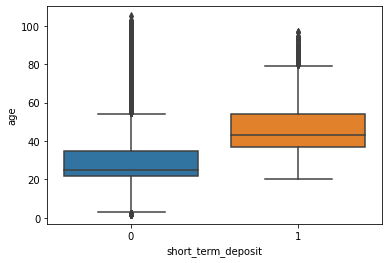

In [14]:
sns.boxplot(data=df_prep, x=TARGET, y="age")

En este gráfico vemos los clientes que tienen "short_term_deposit" según la "region_code" , vemos que la mayoría están en la región número 28 o sea Madrid.

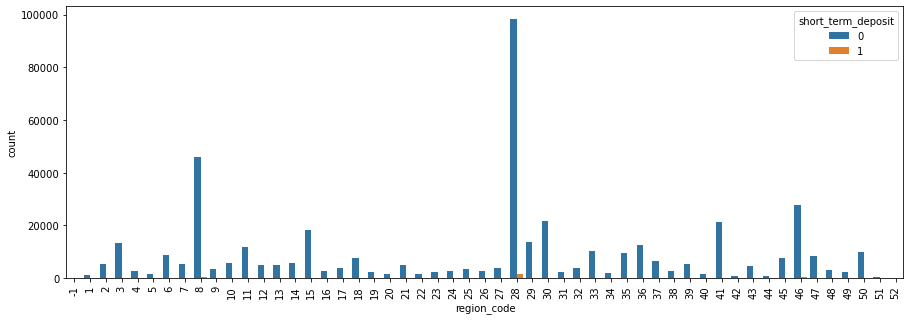

,len,sum,mean
,short_term_deposit,short_term_deposit,short_term_deposit
region_code,,,
-1,159,2,0.012579
1,1112,57,0.051259
2,5262,26,0.004941
3,13614,139,0.010210
4,2680,32,0.011940
5,1574,13,0.008259
6,8789,40,0.004551
7,5351,78,0.014577


In [15]:
relation_with_target(df_prep, "region_code", TARGET)

## Split dataframes

Dividimos los datos en dos particiones, partición de desarrollo (train + test) y partición de validación

In [16]:
splitter = EasyMoneySplitter(DEV_PARTITION_PERIOD, VAL_PARTITION_PERIOD)

### Train partition

Distribución del target en el set de desarrollo, si más del 70% o menos del 30% de los clientes tiene el target en true se hace undersampling automáticamente de la clase mayoritaria. El desarrollo está al 99,98 - 0,012%, no está equilibrado, añadimos una función de undersampling que si es mayor de 0,70, hará el undersampling, en este si lo hace.

Distribucion en la particion de desarrollo:  0.012752217985322015


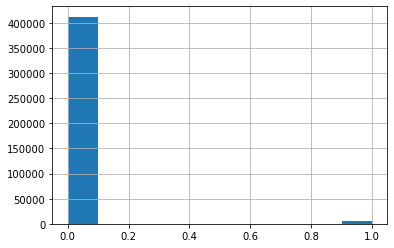

short_term_deposit
0    412172
1      5324
Name: short_term_deposit, dtype: int64


    ******* UNDERSAMPLING: MAJORITY CLASS 0 *******


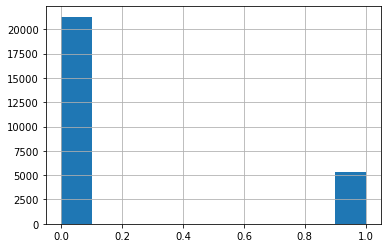

short_term_deposit
0    21296
1     5324
Name: short_term_deposit, dtype: int64


In [17]:
train_df = splitter.get_train_partition(df_prep)
train_target_mean = train_df[TARGET].mean()

print("Distribucion en la particion de desarrollo: ", train_target_mean)
print(hist_plot(train_df, TARGET))

if DO_UNDER_SAMPLING and train_target_mean >= 0.70:
    print("""

    ******* UNDERSAMPLING: MAJORITY CLASS 1 *******""")
    train_df = EasyMoneySplitter.under_sample(train_df, TARGET, False)
    print(hist_plot(train_df, TARGET))

elif DO_UNDER_SAMPLING and train_target_mean <= 0.30:
    print("""

    ******* UNDERSAMPLING: MAJORITY CLASS 0 *******""")
    train_df = EasyMoneySplitter.under_sample(train_df, TARGET, True)
    print(hist_plot(train_df, TARGET))

### Validation partition

Distribución del target en el set de validación. En validación no hacemos undersampling, solo en train. Aquí se ve que en el último mes la mayoría no compró.

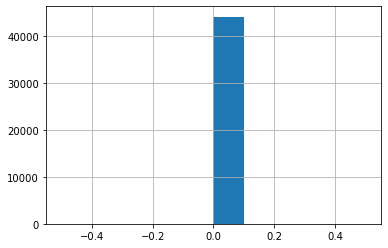

short_term_deposit


0    44197
Name: short_term_deposit, dtype: int64

In [18]:
validation_df = splitter.get_validation_partition(df_prep)
hist_plot(validation_df, TARGET)

#### Partitions

Separación de las particiones. Preparando los datos para el modelo, aquí hacemos la separación del 20% para test.

In [19]:
to_exclude = EXCLUDE_COLUMNS
to_exclude.append(TARGET)

dev_X = train_df.drop(to_exclude, axis=1)
dev_y = train_df[[TARGET]]

X_val = validation_df.drop(to_exclude, axis=1)
y_val = validation_df[[TARGET]]

X_train, X_test, y_train, y_test = train_test_split(dev_X, dev_y, test_size=0.2, random_state=RANDOM_STATE,
                                                    stratify=dev_y)

print(f"""
TRAIN:
    X_train.shape: {X_train.shape}
    y_train.shape: {y_train.shape}
TEST:
    X_test.shape: {X_test.shape}
    y_test.shape: {y_test.shape}
VALIDATION:
    X_val.shape: {X_val.shape}
    y_val.shape: {y_val.shape}
""")


TRAIN:
    X_train.shape: (21296, 140)
    y_train.shape: (21296, 1)
TEST:
    X_test.shape: (5324, 140)
    y_test.shape: (5324, 1)
VALIDATION:
    X_val.shape: (44197, 140)
    y_val.shape: (44197, 1)



## Modelling

Decidimos utilizar el **XGBClassifier** para estimar con una mayor precisión la probabilidad que hay de que un cliente nos compre o no un producto y combina estimaciones de un conjunto de modelos más simples y débiles. Utilizamos AUC . El que va a determinar si el algoritmo es correcto o no es el **AUC Validation.**

In [20]:
%%time
model: XGBClassifier = XGBClassifier(
    max_depth=5,
    min_child_weight=100,
    random_state=RANDOM_STATE,
    use_label_encoder=False
)

eval_set = [(X_test, y_test.values.ravel())]
model.fit(
    X_train,
    y_train.values.ravel(),
    eval_set=eval_set,
    verbose=True,
    eval_metric="auc",
    early_stopping_rounds=10
)

[0]	validation_0-auc:0.94768
[1]	validation_0-auc:0.95426
[2]	validation_0-auc:0.96174
[3]	validation_0-auc:0.96308
[4]	validation_0-auc:0.96408
[5]	validation_0-auc:0.96416
[6]	validation_0-auc:0.96610
[7]	validation_0-auc:0.96694
[8]	validation_0-auc:0.96748
[9]	validation_0-auc:0.96721
[10]	validation_0-auc:0.96836
[11]	validation_0-auc:0.96837
[12]	validation_0-auc:0.96960
[13]	validation_0-auc:0.97030
[14]	validation_0-auc:0.97028
[15]	validation_0-auc:0.97034
[16]	validation_0-auc:0.97036
[17]	validation_0-auc:0.97041
[18]	validation_0-auc:0.97045
[19]	validation_0-auc:0.97051
[20]	validation_0-auc:0.97094
[21]	validation_0-auc:0.97103
[22]	validation_0-auc:0.97087
[23]	validation_0-auc:0.97109
[24]	validation_0-auc:0.97141
[25]	validation_0-auc:0.97144
[26]	validation_0-auc:0.97127
[27]	validation_0-auc:0.97166
[28]	validation_0-auc:0.97185
[29]	validation_0-auc:0.97179
[30]	validation_0-auc:0.97189
[31]	validation_0-auc:0.97183
[32]	validation_0-auc:0.97187
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [27]:
report_df = reporter.record_evaluation(TARGET, model, X_train, y_train, X_test, y_test, X_val, y_val,
                                       train_df[TARGET].mean())
report_df.sort_values(by="date", ascending=False)

C:\Users\alfre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,target,target_mean,date,is_overfitted,roc_auc_train,roc_auc_test,roc_auc_val,accuracy_train,accuracy_test,accuracy_val,recall_train,recall_test,recall_val,precision_train,precision_test,precision_val,f1_score_train,f1_score_test,f1_score_val,model
50,short_term_deposit,0.200000,2022-04-24 20:18:33.170494,False,0.977754,0.973215,0.000000,0.938674,0.935575,0.954861,0.864757,0.864789,0.000000,0.834580,0.822321,0.000000,0.849400,0.843021,0.000000,"XGBClassifier(base_score=0.5, booster='gbtree'..."
49,short_term_deposit,0.200000,2022-04-24 20:17:47.071882,False,0.977754,0.973215,0.000000,0.938674,0.935575,0.954861,0.864757,0.864789,0.000000,0.834580,0.822321,0.000000,0.849400,0.843021,0.000000,"XGBClassifier(base_score=0.5, booster='gbtree'..."
48,em_acount,0.665269,2022-04-24 16:51:30.404775,False,0.922183,0.920140,0.885116,0.869104,0.869748,0.821487,0.929093,0.929927,0.824353,0.880705,0.880910,0.371492,0.904252,0.904755,0.512174,"XGBClassifier(base_score=0.5, booster='gbtree'..."
47,em_acount,0.665269,2022-04-21 23:44:08.957054,False,0.922183,0.920140,0.885116,0.869104,0.869748,0.821487,0.929093,0.929927,0.824353,0.880705,0.880910,0.371492,0.904252,0.904755,0.512174,"XGBClassifier(base_score=0.5, booster='gbtree'..."
46,payroll_account,0.069884,2022-04-21 23:37:13.420288,False,0.993179,0.992358,0.993697,0.984287,0.983515,0.989983,0.894053,0.889364,0.923208,0.882627,0.876539,0.758766,0.888304,0.882905,0.832948,"XGBClassifier(base_score=0.5, booster='gbtree'..."
45,payroll_account,0.200000,2022-04-21 23:22:20.919549,False,0.993132,0.992240,0.993545,0.977216,0.976657,0.982182,0.949739,0.942956,0.960751,0.937183,0.940482,0.607991,0.943419,0.941717,0.744709,"XGBClassifier(base_score=0.5, booster='gbtree'..."
44,debit_card,0.133124,2022-04-21 20:27:58.650938,False,0.891347,0.889704,0.880581,0.878779,0.877681,0.942078,0.228552,0.223388,0.104441,0.621586,0.610988,0.243182,0.334215,0.327160,0.146125,"XGBClassifier(base_score=0.5, booster='gbtree'..."
43,em_acount,0.665269,2022-04-21 20:21:06.229094,False,0.922183,0.920140,0.885116,0.869104,0.869748,0.821487,0.929093,0.929927,0.824353,0.880705,0.880910,0.371492,0.904252,0.904755,0.512174,"XGBClassifier(base_score=0.5, booster='gbtree'..."
42,em_acount,0.665269,2022-04-21 18:48:47.042689,False,0.922183,0.920140,0.885116,0.869104,0.869748,0.821487,0.929093,0.929927,0.824353,0.880705,0.880910,0.371492,0.904252,0.904755,0.512174,"XGBClassifier(base_score=0.5, booster='gbtree'..."
41,em_acount,0.665269,2022-04-21 18:43:08.823390,False,0.922183,0.920140,0.885116,0.869104,0.869748,0.821487,0.929093,0.929927,0.824353,0.880705,0.880910,0.371492,0.904252,0.904755,0.512174,"XGBClassifier(base_score=0.5, booster='gbtree'..."


En estas gráficas aparecen las variables que más peso tienen y que más se repiten. **Weight:** cantidad de veces que esta variable aparece en el DT (entry_date_week)
**Gain:** variables más influyentes (age)

<AxesSubplot:title={'center':'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

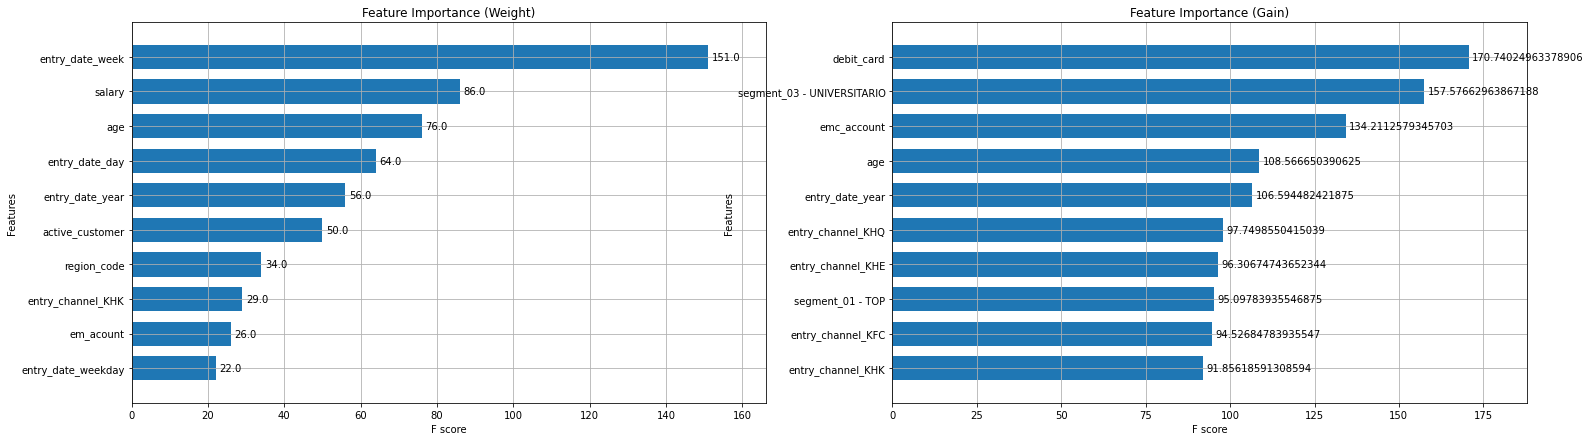

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
# "weight" is the number of times a feature appears in a tree
plot_importance(model, height=0.7, max_num_features=10, ax=ax1, importance_type="weight",
                title="Feature Importance (Weight)")

# "gain" is the average gain of splits which use the feature
plot_importance(model, height=0.7, max_num_features=10, ax=ax2, importance_type="gain",
                title="Feature Importance (Gain)")

En esta matriz podemos ver los TP, FP, TN, FN. Es decir, podemos ver cuál ha sido la predicción del modelo y si realmente esa predicción se ha cumplido o no. Vemos que el modelo se equivoca más a la hora de predecir los clientes que realmente no han comprado, pero el modelo piensa que si. Estos corresponden al cuadrante superior derecho de la confussion matrix. En cambio, existen 1865 clientes que el modelo ha predicho que no iban a comprar pero que realmente han comprado.

A nivel de negocio nos interesa minimizar el número de Falsos Positivos, es decir aquellos clientes que el modelo ha predicho que iban a comprar pero no han comprado. Nuestro principal objetivo es ofrecer productos que se ajusten a las necesidades de los clientes y no enviar campañas que no sean de su interés porque esto puede causar la baja del cliente.

Si la curva AUC es cercana al 1 nos dice que el modelo está prediciendo bien. Siempre se elige la mayor área bajo la curva.

C:\Users\alfre\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


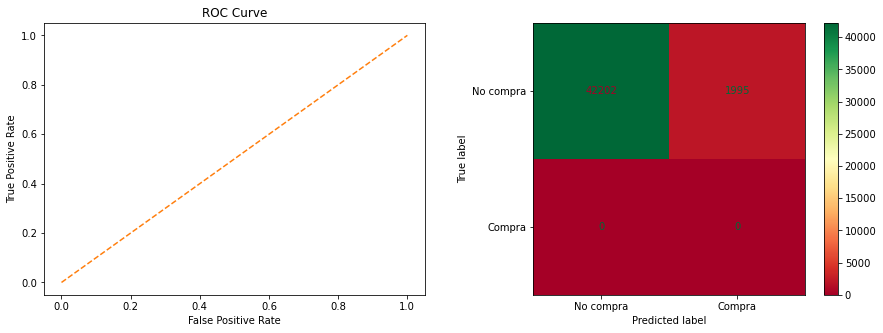

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

fpr, tpr, th = roc_curve(y_val, get_y_score(model, X_val, y_val))
ax1.set_title("ROC Curve")
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], linestyle="--")
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

plot_confusion_matrix(model, X_val, y_val, cmap="RdYlGn", display_labels=["No compra", "Compra"], ax=ax2)

In [24]:
if not IS_RUNNING_LOCAL:
    fig,ax=plt.subplots(figsize=(30,30))
    plot_tree(model,num_trees=1,rankdir="LR",ax=ax)
    plt.show()

### Recomendations

Exportamos en un csv los clientes que nuestro algoritmo ha predicho que comprarían y no lo han hecho, por lo tanto podemos recomendarle este producto. También hemos añadido un filtro para que nos descarte a las personas que tristemente han fallecido.

In [25]:
potential_clients_df = validation_df.copy(deep=True)

prediction = model.predict(X_val)
potential_clients_df["prediction"] = prediction

y_score = get_y_score(model, X_val, y_val)
potential_clients_df["score"] = y_score

potential_clients_df["product_to_sale"] = TARGET

potential_client_filter = (potential_clients_df[TARGET] == 0)\
                          & (potential_clients_df["prediction"] == 1)\
                          & (potential_clients_df["deceased"] == 0)

potential_clients_df = potential_clients_df[potential_client_filter]
potential_clients_df.to_csv(f"{__POTENTIAL_CLIENTS_PATH__}/potential_clients__{TARGET}.csv")
potential_clients_df

,pk_cid,short_term_deposit,pk_partition,active_customer,region_code,gender,age,deceased,loans,mortgage,...,country_id_RO,country_id_RU,country_id_SA,country_id_SE,country_id_SN,country_id_US,country_id_VE,prediction,score,product_to_sale
5,31365,0,2019-05-28,1,28,1,85,0,0,0,...,0,0,0,0,0,0,0,1,0.717601,short_term_deposit
7,33620,0,2019-05-28,1,28,1,51,0,0,0,...,0,0,0,0,0,0,0,1,0.769348,short_term_deposit
31,91532,0,2019-05-28,1,8,0,64,0,0,0,...,0,0,0,0,0,0,0,1,0.565443,short_term_deposit
34,97947,0,2019-05-28,1,28,0,69,0,0,0,...,0,0,0,0,0,0,0,1,0.880247,short_term_deposit
41,110831,0,2019-05-28,1,28,1,48,0,0,0,...,0,0,0,0,0,0,0,1,0.577011,short_term_deposit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43730,1553090,0,2019-05-28,1,28,0,75,0,0,0,...,0,0,0,0,0,0,0,1,0.542781,short_term_deposit
43963,1553389,0,2019-05-28,1,28,0,60,0,0,0,...,0,0,0,0,0,0,0,1,0.557420,short_term_deposit
43964,1553390,0,2019-05-28,1,28,1,63,0,0,0,...,0,0,0,0,0,0,0,1,0.551937,short_term_deposit
44082,1553541,0,2019-05-28,1,49,0,54,0,0,0,...,0,0,0,0,0,0,0,1,0.532079,short_term_deposit


### Conclusions

Últimas métricas, aquí vemos los resultados generales.

In [26]:
columns = [
    "target",
    "target_mean",
    "roc_auc_test",
    "roc_auc_val",
    "accuracy_test",
    "accuracy_val",
    "recall_test",
    "recall_val",
    "precision_test",
    "precision_val",
    "f1_score_test",
    "f1_score_val",
]
report_df.tail(1)[columns].T

,49
target,short_term_deposit
target_mean,0.2
roc_auc_test,0.973215
roc_auc_val,0.0
accuracy_test,0.935575
accuracy_val,0.954861
recall_test,0.864789
recall_val,0.0
precision_test,0.822321
precision_val,0.0
